# Template for Practical work on the Conversion of sampling frequency and STFT


*From R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2020*

**python version : 3.6**

In [35]:
import os, sys, wave, struct

import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Audio

from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write

## Functions

In [36]:
def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [37]:
data_path = os.getcwd()
filename = 'caravan_48khz.wav'
sound = os.path.join(data_path, filename) 

### **Using wave**

In [38]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805733, comptype='NONE', compname='not compressed')


In [39]:
play = False
if play :
    play_sound(sound) 

In [40]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

In [41]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

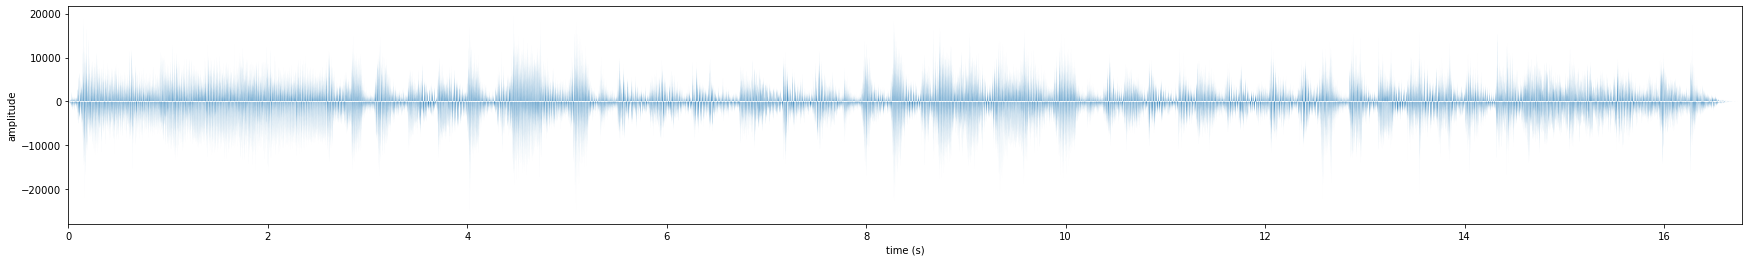

In [42]:
plot_sound(x, times)

## I - Conversion of sampling rate

Question 1:

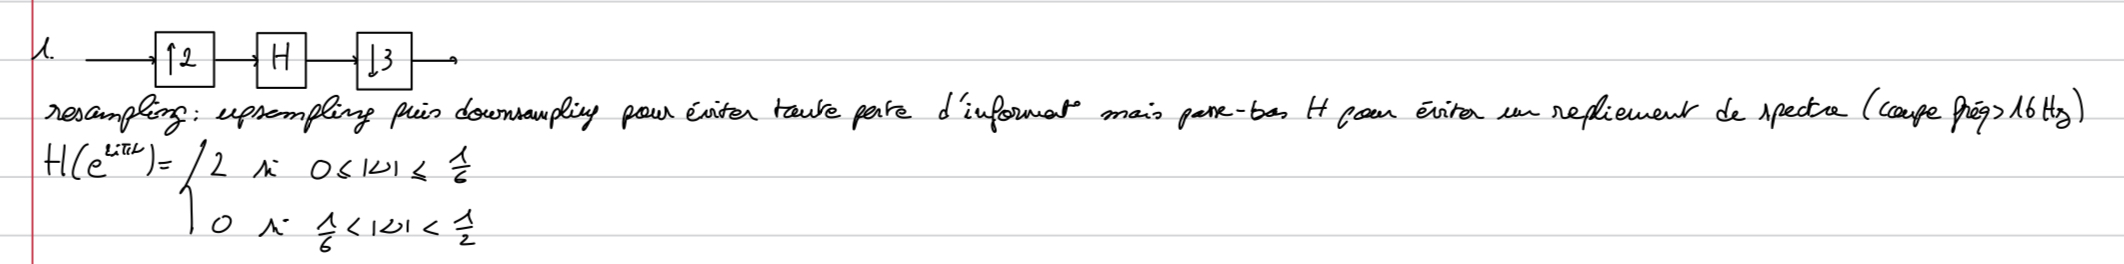

Question 2:

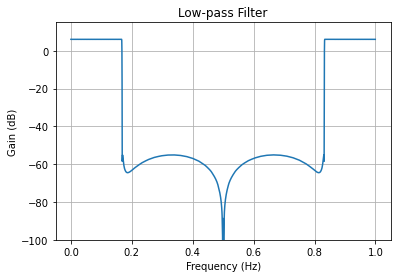

In [43]:
from scipy import signal
def plot_response(w, h):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(w, 20*np.log10(np.abs(h)))
    ax.set_ylim(-100, 15)
    ax.grid(True)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Gain (dB)')
    ax.set_title("Low-pass Filter")

l = 2000
h = signal.remez(l,[0,1/6,1/6*1.01,0.5],[2,0])
H = np.fft.fft(h,l)
freq = [k/l for k in range(l)]
plot_response(freq, H)
plt.show()


Question 3:

In [44]:
from scipy.signal import lfilter
def simple_resampling(x,h,L,M):

    x_L = np.zeros(L*(len(x)))
    x_L[::L] = x

    return lfilter(h,[1],x_L)[::M]

Question 4:

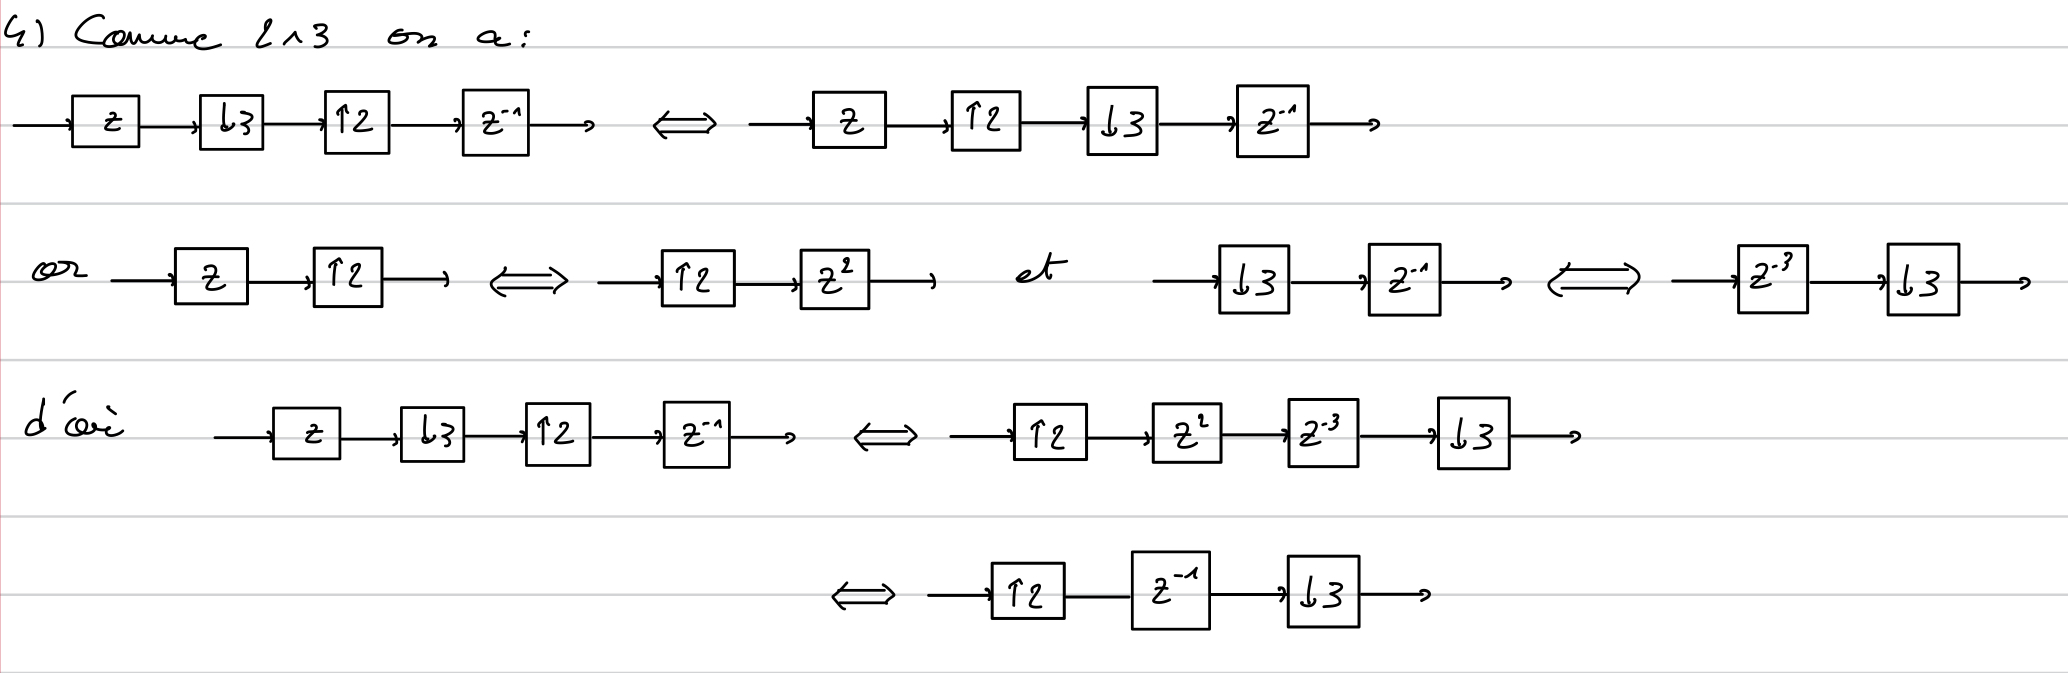

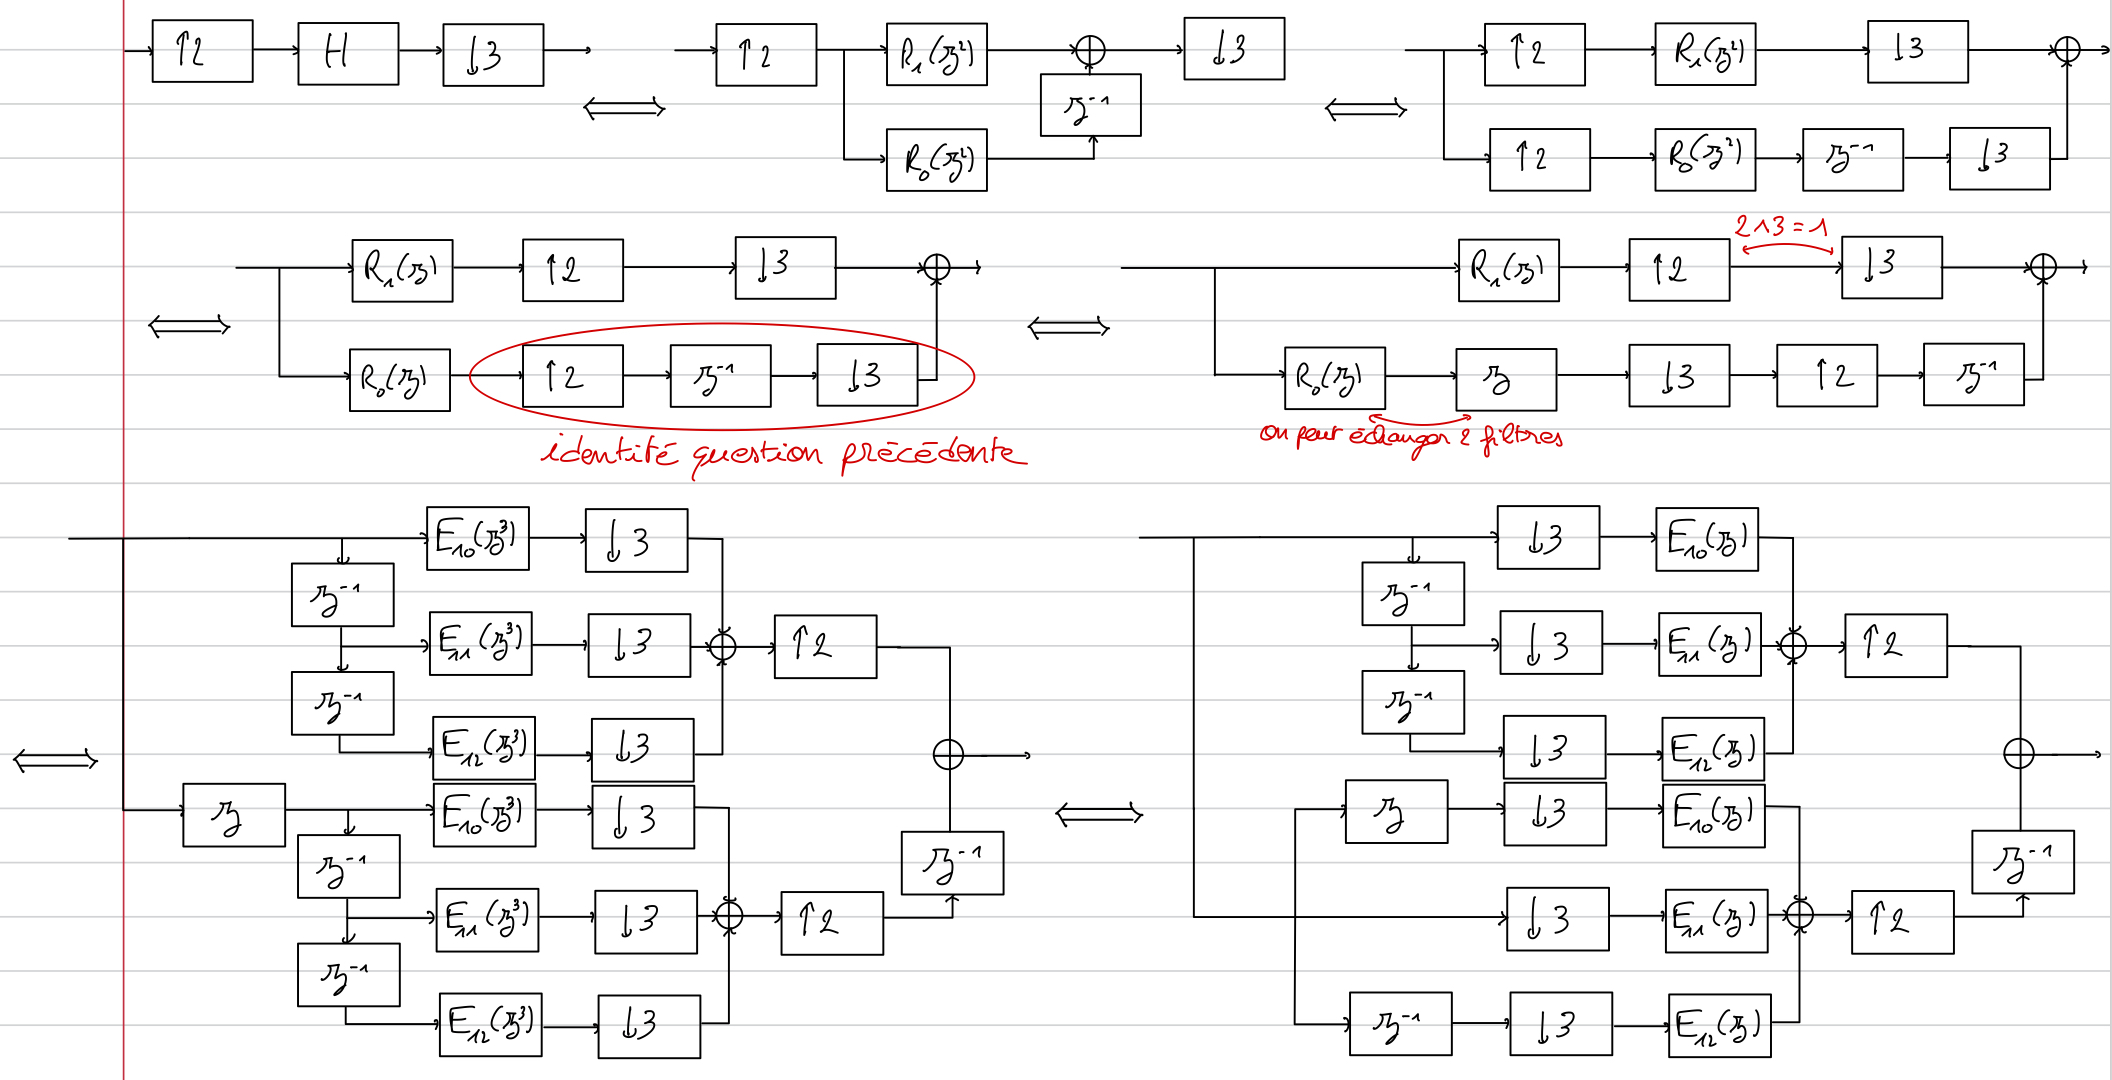

Question 5:

In [45]:
from math import gcd

def efficient_resampling(x, h, L, M):
    '''fonction permettant de resampler de manière efficace x pour tout M et L premiers'''

    if gcd(L, M) != 1:
        raise ValueError(f"{M} et {L} ne sont pas premiers entre eux.")
    
    # Ajout de 0 à la fin de x et h pour que leur taille soit divisible par M (si c'est déjà le cas aucun 0 n'est ajouté)
    # Les composantes polyphases de h et les sous-séquences décimées de x auront donc toutes la même taille
    x = np.append(x, np.zeros((M - len(x) % M) % M))
    h = np.append(h, np.zeros((M - len(x) % M) % M))
    
    
    # Calcul des composantes polyphases de type 2 de h avec le facteur de décimation L
    r_list = [h[L-i-1::L] for i in range(L)]

    # Calcul des composantes polyphases de type 1 de chaque composante de type 2 dans r avec le facteur de décimation M
    e_list = [[r[i::M] for i in range(M)] for r in r_list]


    # Création des sous-séquences de x après shift (passage dans un filtre z ou z^-1) puis décimation de facteur M
    x_shift_decim = [np.roll(x, i)[::M] for i in [-k for k in range(L)] + list(range(M-1, 0, -1))]

    # x_sorties stock l'ensemble des sommes de sous-séquences de x après passage dans les composantes polyphases et insertion de 0
    x_exit = []

    for n in range(L):
        sum_exit = lfilter(e_list[n][0],[1],x_shift_decim[M+n-1]) #initialisation pour k=0
        for k in range(1,M):
            sum_exit += lfilter(e_list[n][k],[1],x_shift_decim[M+n-k-1])

        # Insertion de 0
        sum_inserted = np.zeros(L*(len(sum_exit)))
        sum_inserted[::L] = sum_exit
        x_exit.append(sum_inserted)

    # Calcul de la somme finale de chaque somme partielle après shifting
    y = x_exit[-1]
    for i,x_s in enumerate(x_exit[:-1]): 
        y += np.roll(x_s,L-1-i)

    return y


Question 6:

In [46]:
from time import time

L=2
M=3
n_simulations = 10

simple_start = time()
for k in range(10):
    y_simple = simple_resampling(x,h,L,M)
delta_simple = (time() - simple_start)/n_simulations

efficient_start = time()
for k in range(n_simulations):
    y_efficient = efficient_resampling(x, h, L, M)
delta_efficient = (time() - efficient_start)/n_simulations

print(f"L'algorithme simple a un temps d'exécution moyen de {delta_simple}s et l'efficace de {delta_efficient}s")
print(f"L'algorithme efficace est donc {delta_simple/delta_efficient} fois plus rapide que le simple")
print(f"Théoriquement on devrait trouver {M} fois plus rapide car on a {M*L} opérations en plus mais chaque support de filtre est divisé par {M*L}, de plus les opérations sont effectuées à la fréquence Fe/{M}")

L'algorithme simple a un temps d'exécution moyen de 0.3914206504821777s et l'efficace de 0.1279815435409546s
L'algorithme efficace est donc 3.0584148280484023 fois plus rapide que le simple
Théoriquement on devrait trouver 3 fois plus rapide car on a 6 opérations en plus mais chaque support de filtre est divisé par 6, de plus les opérations sont effectuées à la fréquence Fe/3


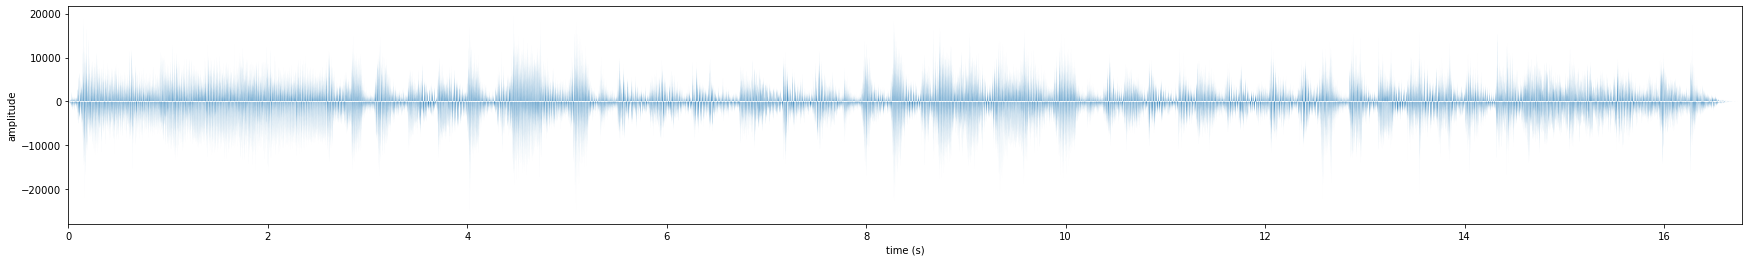

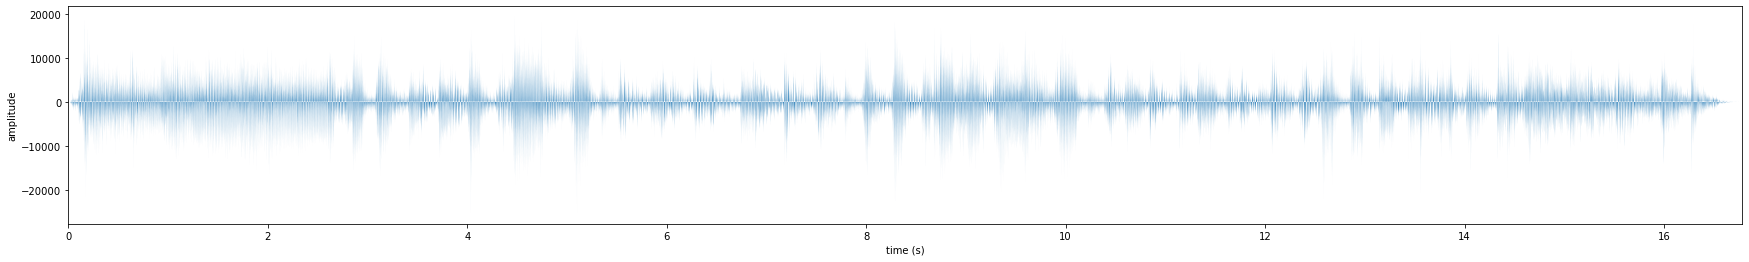

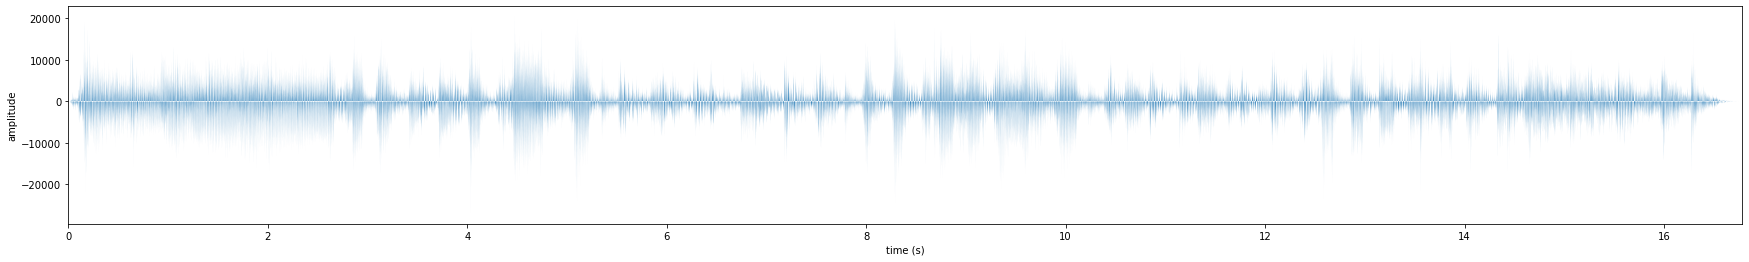

In [47]:
plot_sound(x,np.arange(len(x))*timestep,'original sound')
plot_sound(y_simple,np.arange(len(y_simple))*timestep*M/L,'simple resampling')
plot_sound(y_efficient,np.arange(len(y_efficient))*timestep*M/L,'efficient resampling')

## II - STFT audio equalization

Question 1:

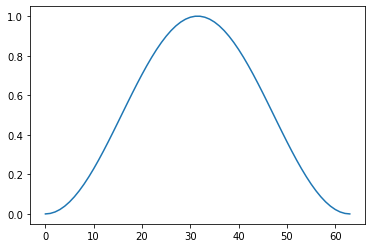

C:\Users\natha\AppData\Local\Temp/ipykernel_10184/1167419493.py:10: RuntimeWarning: divide by zero encountered in log10
  plt.plot(freqs_shifted,20*np.log10(np.abs(w_tf_shifted)))


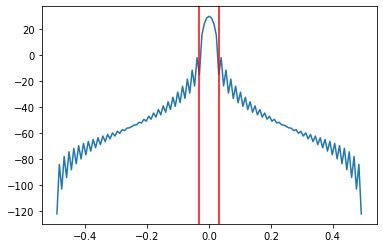

La largeur du lobe principal est 0.0625


In [48]:
Nw = 64
w = np.hanning(Nw)
plt.plot(w)
plt.show()
M = 128
w_tf = np.fft.fft(w,M)
freqs = np.fft.fftfreq(M)
w_tf_shifted = np.fft.fftshift(w_tf)
freqs_shifted = np.fft.fftshift(freqs)
plt.plot(freqs_shifted,20*np.log10(np.abs(w_tf_shifted)))
plt.axvline(2/Nw,color='r')
plt.axvline(-2/Nw,color='r')
plt.show()

print(f'La largeur du lobe principal est {4/Nw}')


Question 2:

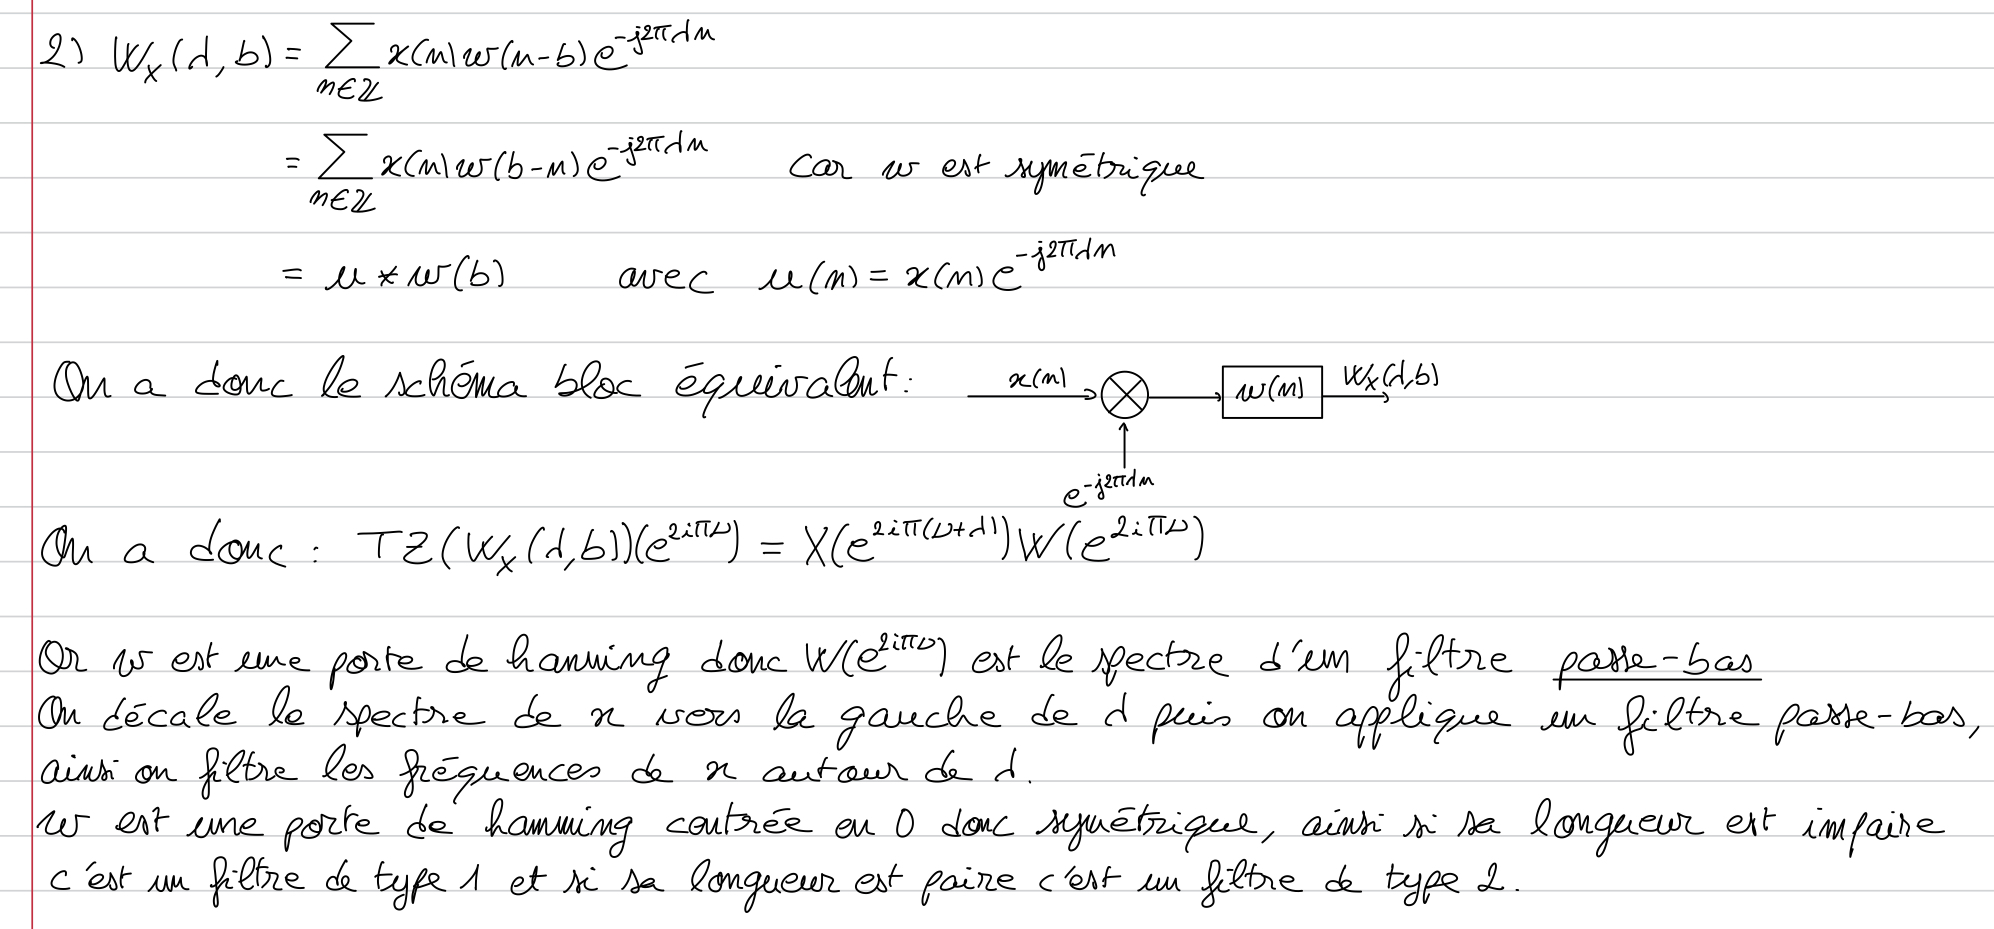

Question 3:

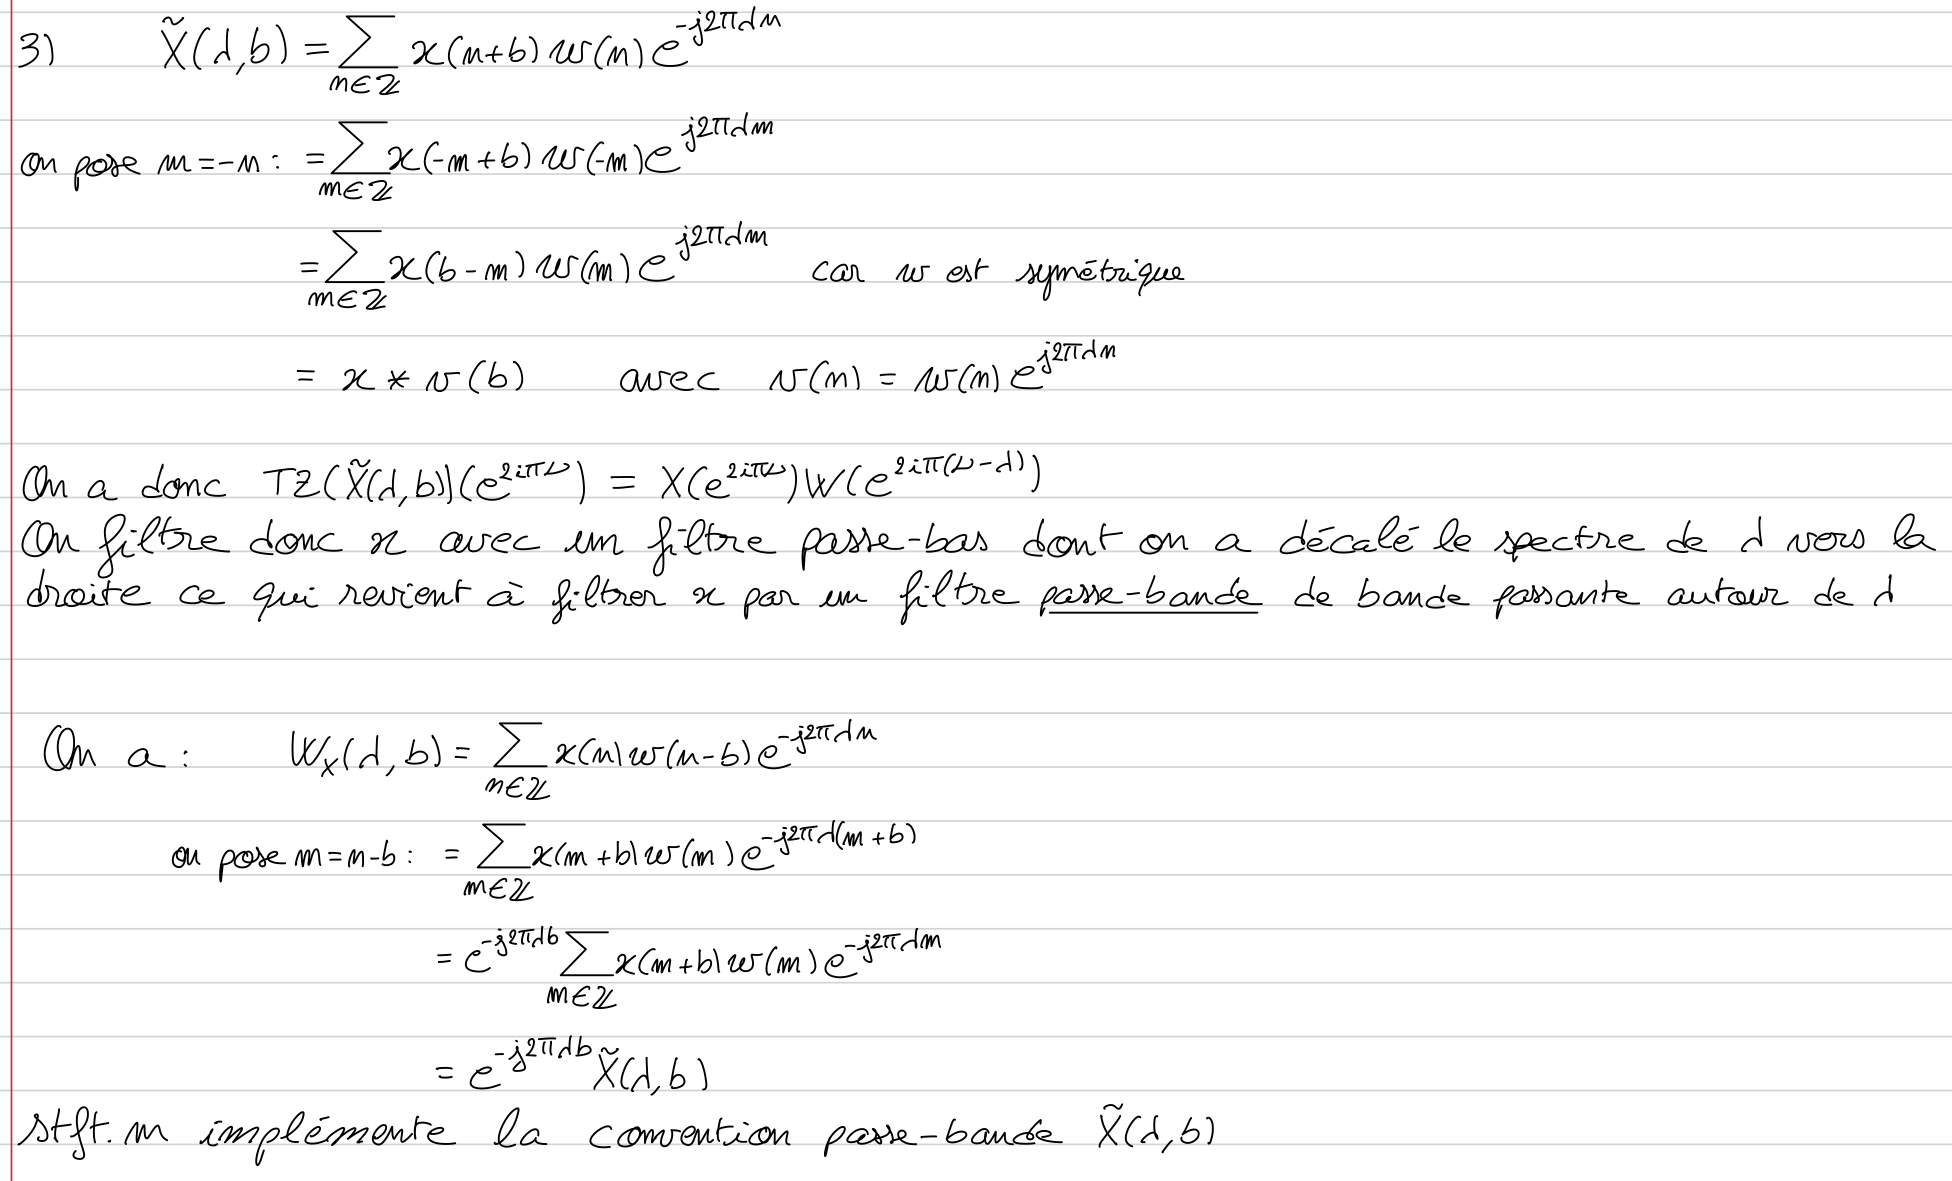

Question 4:

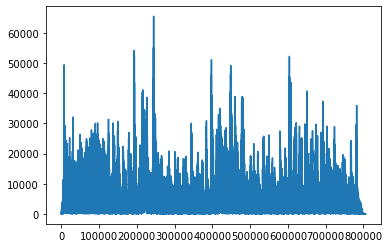

In [49]:
M=32
R=1
Nw=16
N = x.shape[0]
w = np.hanning(Nw)
ws = w.copy
Nt = np.rint((N - Nw) / R)
Nt = Nt.astype(int)
Xtilde = np.zeros((M,Nt),dtype=complex)
for u in np.arange(0,Nt).reshape(-1):
    deb = u * R + 1
    fin = deb + Nw
    tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))],w)
    X = np.fft.fft(tx,M)
    Xtilde[:,u] = X

Xtilde_3 = np.abs(Xtilde[3,:])
plt.plot(Xtilde_3)
plt.show()

## Overlap-add reconstruction

Question 5:

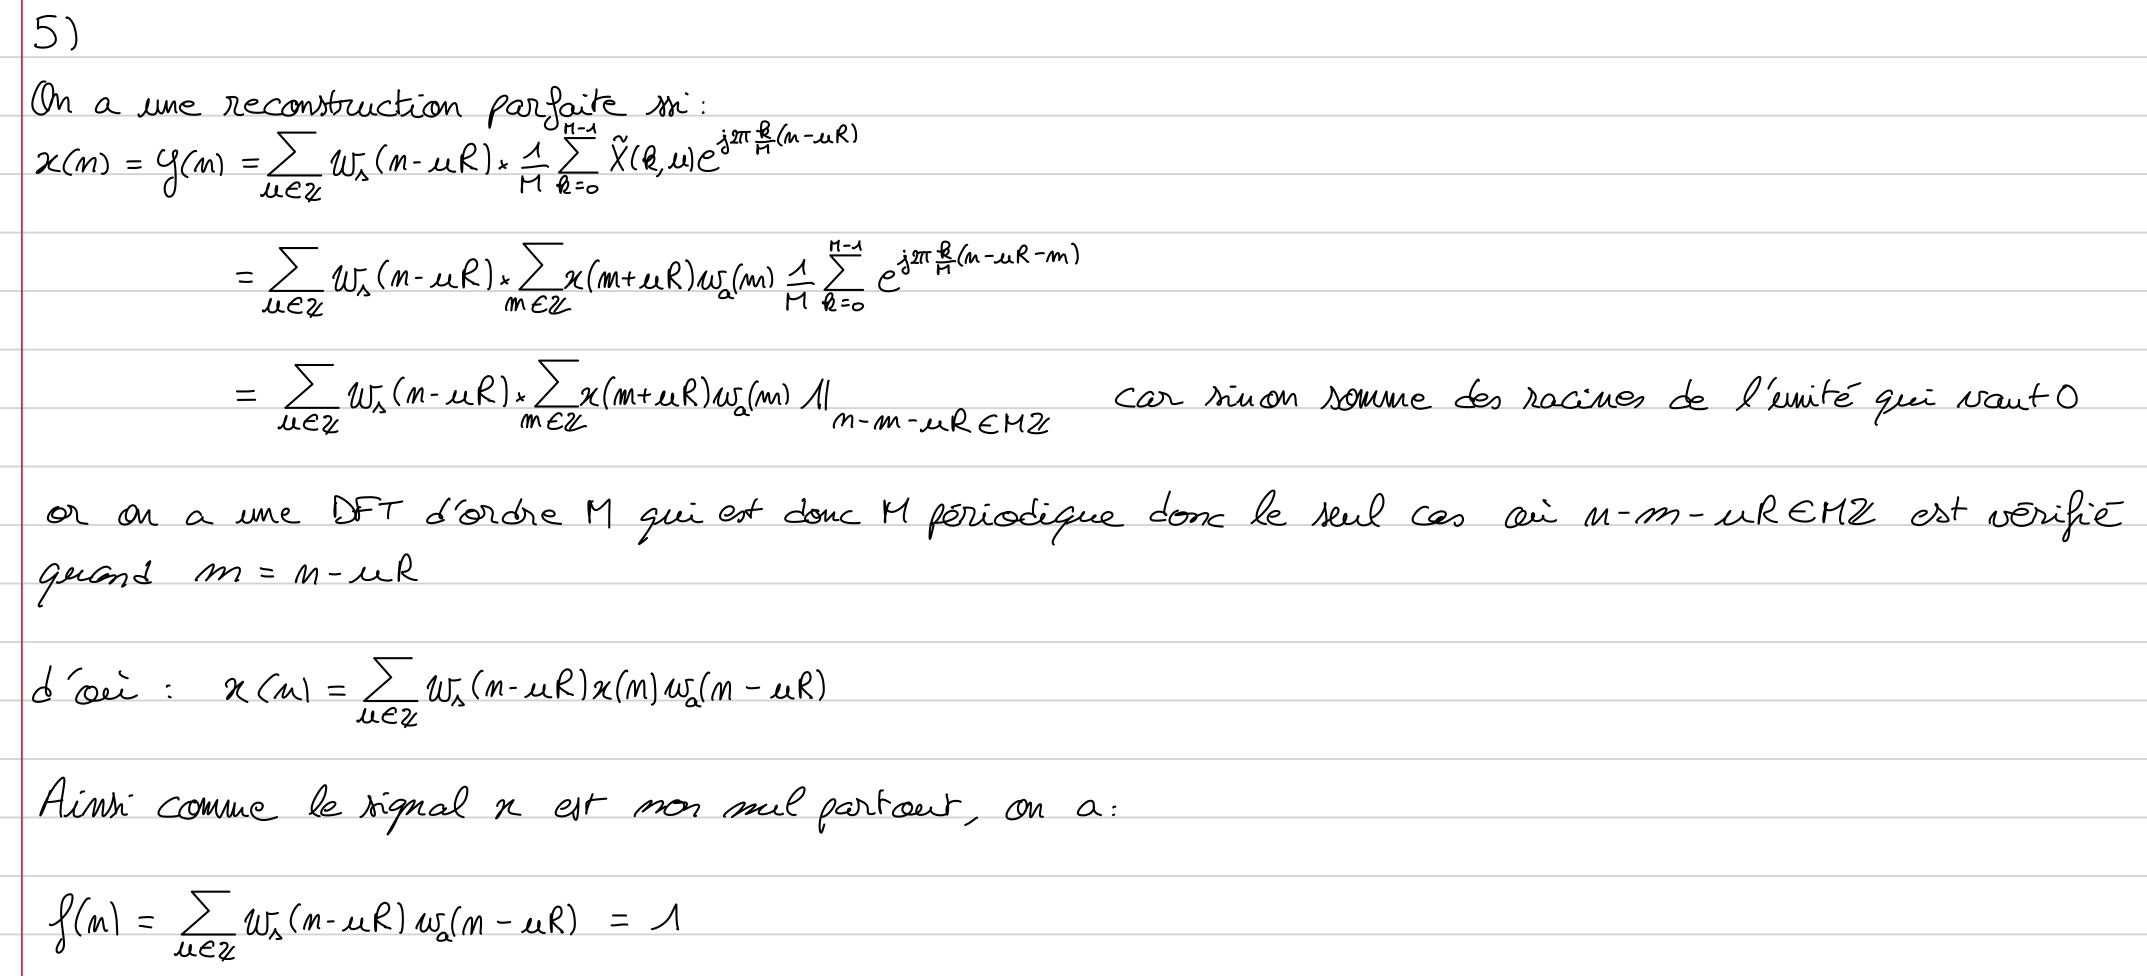

In [50]:
def ola(w = None,hop = None,Nb = 10): 
# function output = ola(w,hop,Nb)
# realise l'addition-recouvrement de la fenetre w,
# avec un décalage hop et un nombre Nb de fenetres.
# par defaut Nb = 10;
    
    w = w[:, np.newaxis]
    N = len(w)
    output = np.zeros(((Nb - 1) * hop + N,1)) # réserve l'espace memoire
    
    for k in np.arange(0,Nb).reshape(-1):
        deb = k* hop
        fin = deb + N
        output[np.arange(deb,fin)] = output[np.arange(deb,fin)] + w # OLA
    
    return output

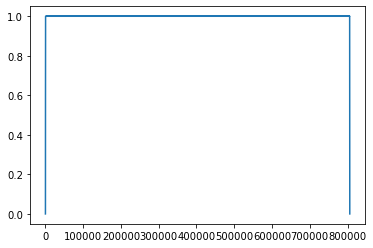

In [51]:
Nw = 512
hop = int(0.25*Nw)
Nb = int(len(x)/hop)
h = np.hanning(Nw)
ws = h/np.linalg.norm(h)
h_carre = np.multiply(ws,ws)*hop
ola = ola(h_carre, hop, Nb)
plt.plot(ola)

Question 6:

In [52]:
y = np.multiply(ola[len(x):],x)

display(Audio(data=x,rate=Fs))
display(Audio(data=y[0,:],rate=Fs))